imports and config

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp, solve_bvp
import torch

NOISE_STD = 0.1

# Second Order ODE

$\epsilon y^{\prime \prime} + y^\prime + y = 0$, $0 \le x \le 1$  
$y(0)=a, y(1)=b$

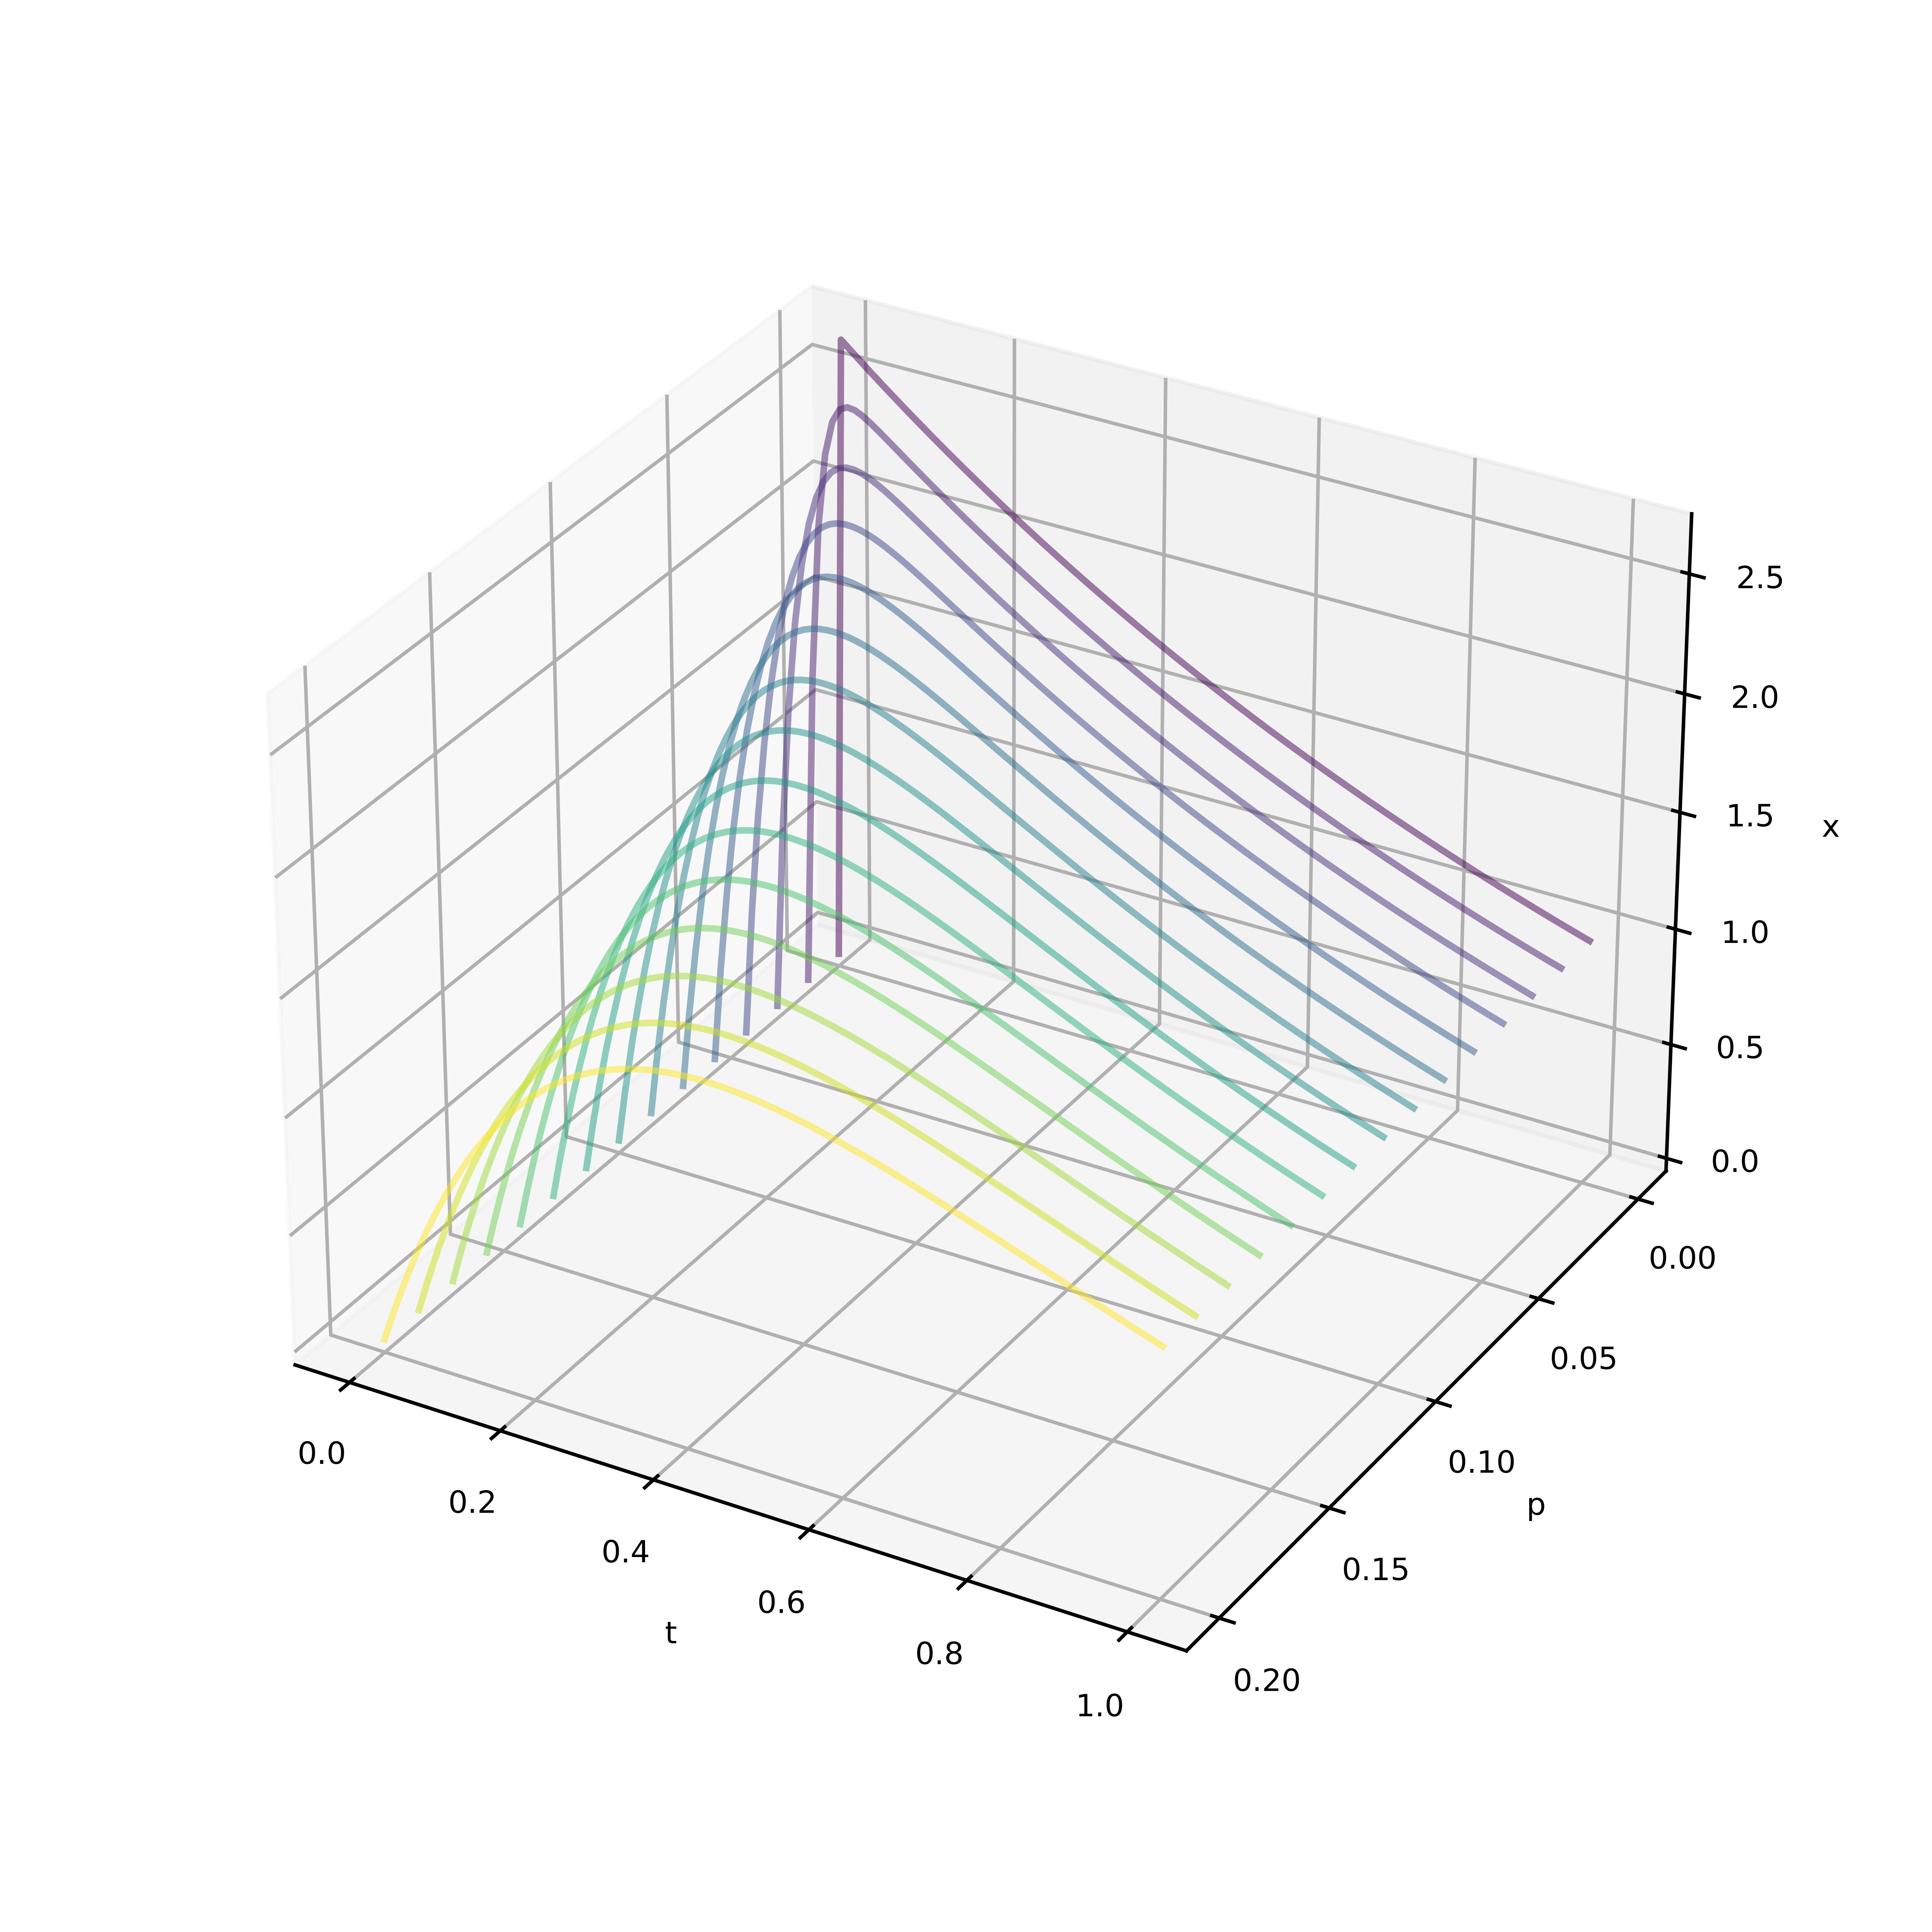

In [53]:
def analytical_solution(x, epsilon):
    lambda1 = (-1 + np.sqrt(1 - 4 * epsilon)) / (2 * epsilon)
    lambda2 = (-1 - np.sqrt(1 - 4 * epsilon)) / (2 * epsilon)
    y = (np.exp(lambda1 * x) - np.exp(lambda2 * x)) / (np.exp(lambda1) - np.exp(lambda2))
    return y

def F(x, epsilon):
    lambda1 = (-1 + (1 - 4 * epsilon)**0.5) / (2 * epsilon)
    lambda2 = (-1 - (1 - 4 * epsilon)**0.5) / (2 * epsilon)
    return (torch.exp(lambda1 * x) - torch.exp(lambda2 * x)) / (np.e**lambda1 - np.e**lambda2)

# epsilon = 0.2
# epsilons = [0.2, 0.1, 0.05, 0.001, 0.0001]
epsilons = np.linspace(0.2, 0.0002, 15)[::-1]
x_ = np.linspace(0, 1, 100)
colors = plt.cm.viridis(np.linspace(0, 1, len(epsilons)))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 6), dpi=1000)
ax.set_xlabel("t")
ax.set_ylabel("p")
ax.set_zlabel("x")
ax.invert_yaxis()
# xx = []
# yy = []
# zz = []
for i, epsilon in enumerate(epsilons):
    y_i = analytical_solution(x_, epsilon)
    ax.plot(x_, epsilon * np.ones_like(x_), y_i, color=colors[i], alpha=0.5)
ax.set_yticks([0.2, 0.15, 0.1, 0.05, 0])
ax.set_box_aspect(None, zoom=0.85)
fig.savefig("bvp.png", dpi=1000, bbox_inches="tight")

Generate training data

/var/folders/s5/91gspn4x2j9c_j33qvjvrlt00000gn/T/ipykernel_20741/3817402783.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x_sweep_.numpy(), y_sweep_.numpy(), "k-", color="black", alpha=0.5)


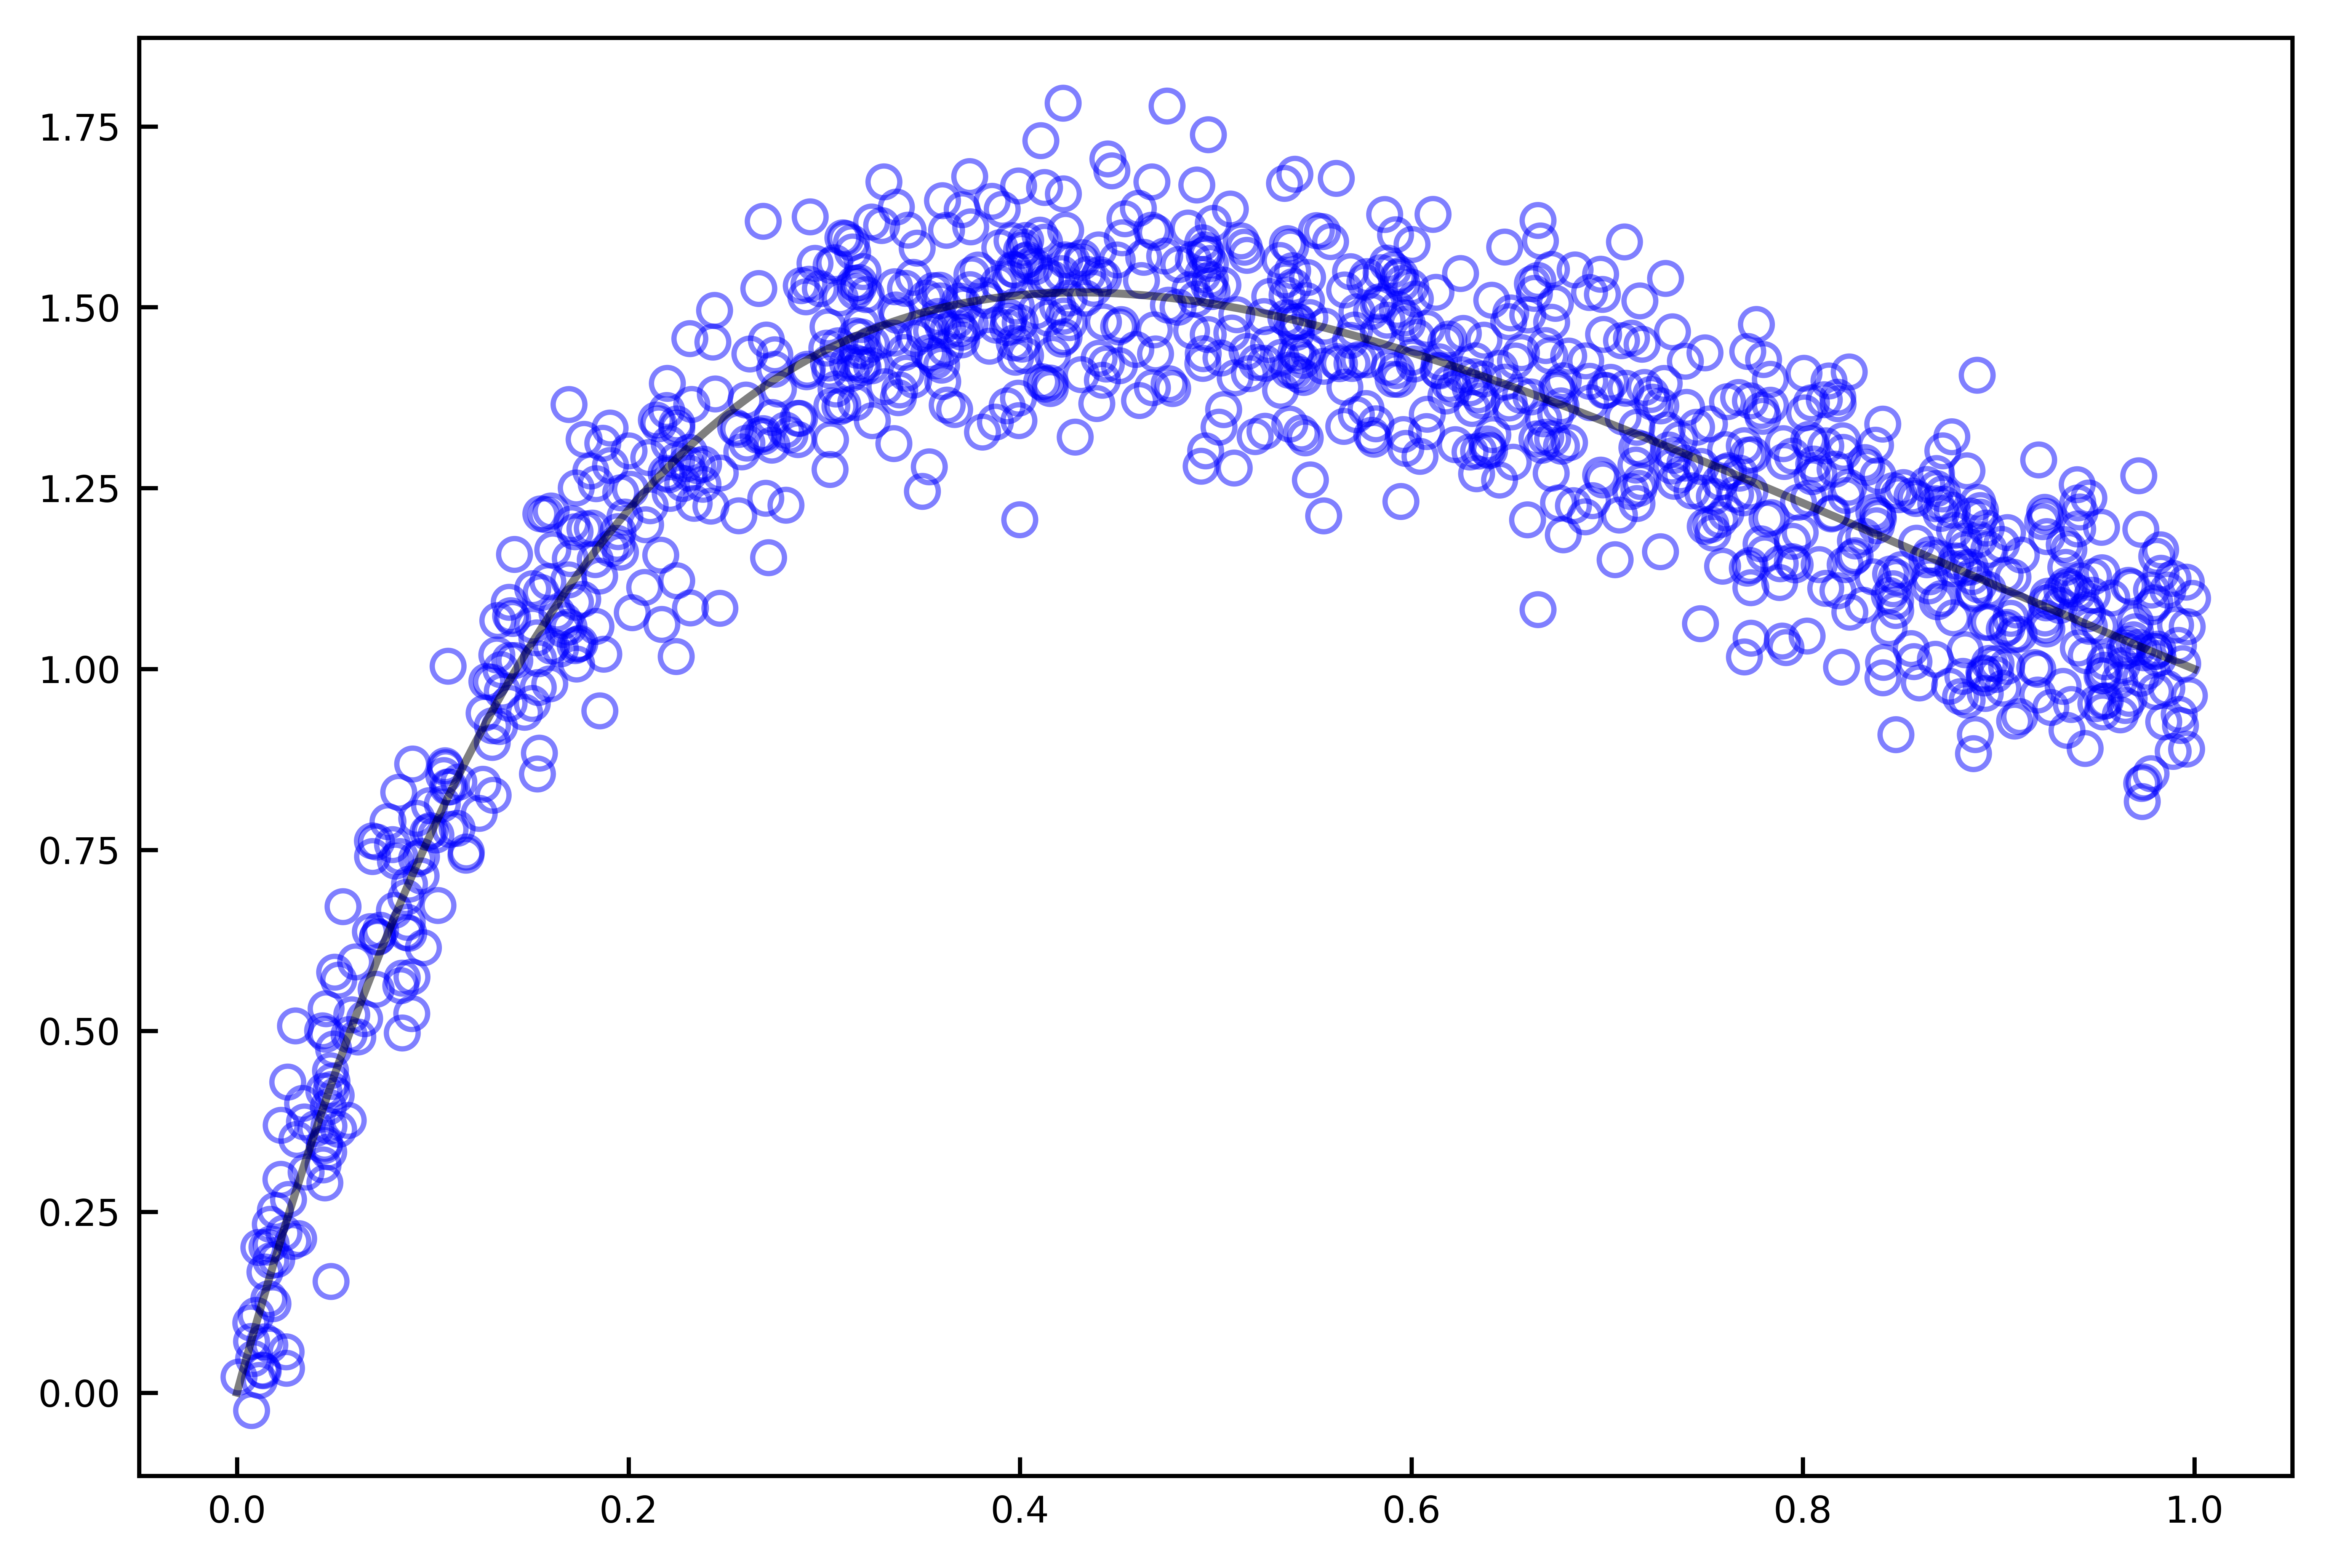

In [54]:
x_ = torch.rand((1000, 1))
x_sweep_ = torch.linspace(0, 1, 1000).reshape(-1, 1)
y_ = F(x_, 0.2)
y_sweep_ = F(x_sweep_, 0.2)
noise_ = torch.normal(0, NOISE_STD, x_.shape)
yn_ = y_ + noise_
fig, ax = plt.subplots(figsize=(6, 4), dpi=1000)
ax.plot(x_sweep_.numpy(), y_sweep_.numpy(), "k-", color="black", alpha=0.5)
ax.scatter(x_.numpy(), yn_.numpy(), marker="o", color="blue", facecolor="none", alpha=0.5)

In [55]:
from sekf.modeling import AbstractNN, init_weights

class SimpleNN(AbstractNN):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(1, 16)
        self.fc2 = torch.nn.Linear(16, 16)
        self.fc3 = torch.nn.Linear(16, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        # x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
    
M = SimpleNN()
M.apply(init_weights)

opt = torch.optim.Adam(M.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()
for i in range(10_000):
    opt.zero_grad()
    y_pred = M(x_)
    loss = loss_fn(y_pred, yn_)
    loss.backward()
    opt.step()
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}", end="\r")

/var/folders/s5/91gspn4x2j9c_j33qvjvrlt00000gn/T/ipykernel_20741/3177206198.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_sweep_.numpy(), y_sweep_.numpy(), "k-", color="black", alpha=0.5)


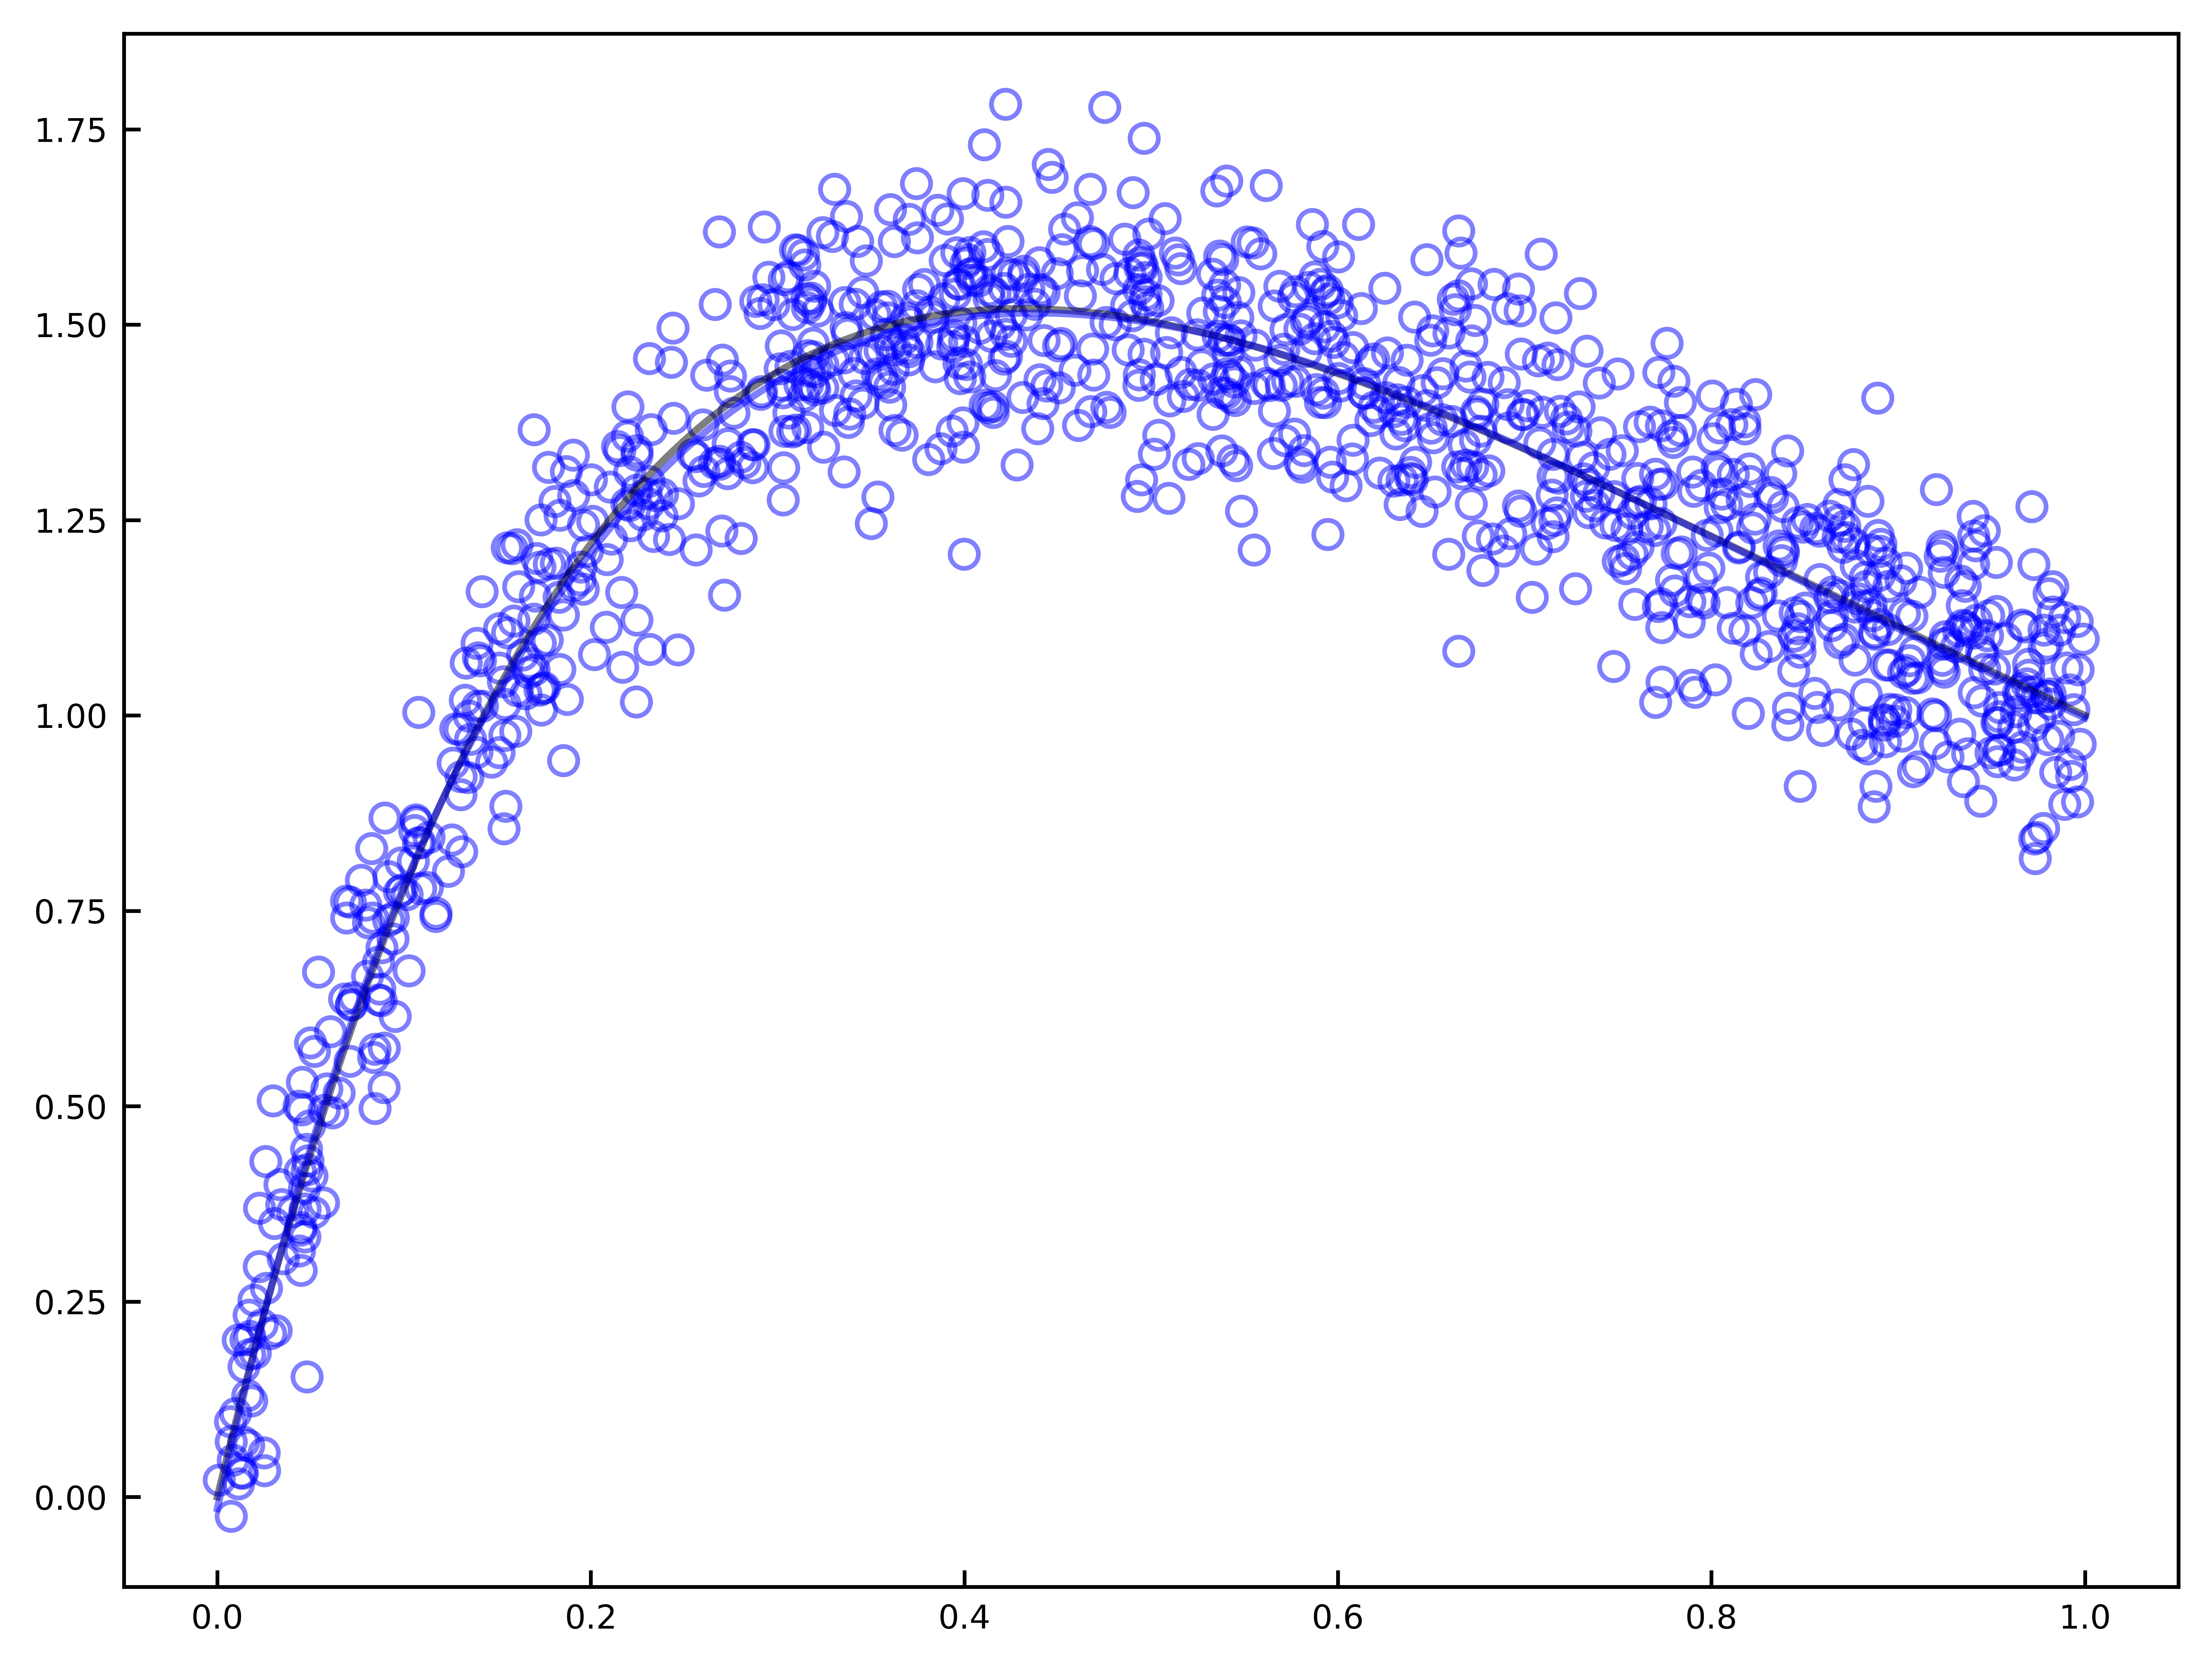

In [58]:
plt.plot(x_sweep_.numpy(), y_sweep_.numpy(), "k-", color="black", alpha=0.5)
plt.scatter(x_.numpy(), yn_.numpy(), marker="o", color="blue", facecolor="none", alpha=0.5)
plt.plot(x_sweep_.numpy(), M(x_sweep_).detach().numpy(), "b-", alpha=0.5)